# Functions María

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, f_oneway, mannwhitneyu

In [2]:
# Load the datasets
titanic_df = pd.read_csv('../data/titanic.csv')
cities_df = pd.read_csv('../data/california_cities.csv')
inmo_df = pd.read_csv('../data/ejemplo_housing.csv')
flights_df = pd.read_csv('../data/dataset_viajes_jun23.csv')
customers_df = pd.read_csv('../data/Marketing-Customer-Analysis.csv')

In [3]:
cities_df

,Unnamed: 0,city,latd,longd,elevation_m,elevation_ft,population_total,area_total_sq_mi,area_land_sq_mi,area_water_sq_mi,area_total_km2,area_land_km2,area_water_km2,area_water_percent
0,0,Adelanto,34.576111,-117.432778,875.0,2871.0,31765,56.027,56.009,0.018,145.107,145.062,0.046,0.03
1,1,AgouraHills,34.153333,-118.761667,281.0,922.0,20330,7.822,7.793,0.029,20.260,20.184,0.076,0.37
2,2,Alameda,37.756111,-122.274444,NaN,33.0,75467,22.960,10.611,12.349,59.465,27.482,31.983,53.79
3,3,Albany,37.886944,-122.297778,NaN,43.0,18969,5.465,1.788,3.677,14.155,4.632,9.524,67.28
4,4,Alhambra,34.081944,-118.135000,150.0,492.0,83089,7.632,7.631,0.001,19.766,19.763,0.003,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,477,Yountville,38.403056,-122.362222,30.0,98.0,2933,1.531,1.531,0.000,3.966,3.966,0.000,0.00
478,478,Yreka,41.726667,-122.637500,787.0,2582.0,7765,10.053,9.980,0.073,26.036,25.847,0.188,0.72
479,479,YubaCity,39.134722,-121.626111,18.0,59.0,64925,14.656,14.578,0.078,37.959,37.758,0.201,0.53
480,480,Yucaipa,34.030278,-117.048611,798.0,2618.0,51367,27.893,27.888,0.005,72.244,72.231,0.013,0.02


### Reviewed: describe_df()

In [4]:
def describe_df(df): 
    """
    Generates a summary DataFrame describing the input DataFrame's data types, percentage of missing values, number of unique values and cardinality (percentage of unique values).
    
    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to be described.
    
    Returns
    -------
    df_summary: pd.DataFrame
        A DataFrame with a summary of data types, missing values, unique values and cardinality for each column of the input DataFrame.
    
    Raises
    ------
    TypeError
        If the input is not a pandas DataFrame.
    
    ValueError
        If the DataFrame is empty.
    """

    # Validate input type
    if not isinstance(df, pd.DataFrame):
        raise TypeError(f'Input must be a pandas DataFrame, but received {type(df).__name__}.')
    
    # Calculate the length of the DataFrame once
    num_rows = len(df)
    
    # Validate DataFrame length to prevent dividing by 0 later on
    if num_rows == 0:
        raise ValueError('The DataFrame is empty.')
    
    # Calculate data types, missing values percentage, unique values and cardinality
    data_type = df.dtypes
    missings = round(df.isna().sum() / num_rows * 100, 2)
    unique_values = df.nunique()
    cardin = round(unique_values / num_rows * 100, 2)
    
    # Construct the summary DataFrame
    df_summary = pd.DataFrame({
        'DATA_TYPE': data_type,
        'MISSINGS (%)': missings,
        'UNIQUE_VALUES': unique_values,
        'CARDIN (%)': cardin
    }).T

    return df_summary


In [5]:
def describe_df_extra(df, count = False): 
    """
    Generates a summary DataFrame describing the input DataFrame's data types, percentage of missing values, number of unique values, cardinality (percentage of unique values), and optionally, the count of non-null values.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to be described.
    
    count : bool, optional
        If True, includes the count of non-null values in each column (default is False).
    
    Returns
    -------
    df_summary: pd.DataFrame
        A DataFrame with a summary of data types, missing values, unique values, cardinality, and optionally, the count of non-null values for each column.
    
    Raises
    ------
    TypeError
        If the input is not a pandas DataFrame.
    
    ValueError
        If the DataFrame is empty.
    """

    # Validate input type
    if not isinstance(df, pd.DataFrame):
        raise TypeError(f'Input must be a pandas DataFrame, but received {type(df).__name__}.')
    
    # Calculate the length of the DataFrame once
    num_rows = len(df)
    
    # Validate DataFrame length to prevent dividing by 0 later on
    if num_rows == 0:
        raise ValueError('The DataFrame is empty.')
    
    # Calculate data types, missing values percentage, unique values and cardinality
    data_type = df.dtypes
    missings = round(df.isna().sum() / num_rows * 100, 2)
    unique_values = df.nunique()
    cardin = round(unique_values / num_rows * 100, 2)
    
    # Construct the summary DataFrame
    df_summary = pd.DataFrame({
        'DATA_TYPE': data_type,
        'MISSINGS (%)': missings,
        'UNIQUE_VALUES': unique_values,
        'CARDIN (%)': cardin
    })
    
    # Optionally add the count of non-null values and rearrange the columns
    if count:
        not_null_count = df.notna().sum()
        df_summary.insert(1, 'NOT-NULL COUNT', not_null_count)

    return df_summary.T


In [6]:
describe_df(titanic_df)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
DATA_TYPE,int64,int64,object,float64,int64,int64,float64,object,object,object,bool,object,object,object,bool
MISSINGS (%),0.0,0.0,0.0,19.87,0.0,0.0,0.0,0.22,0.0,0.0,0.0,77.22,0.22,0.0,0.0
UNIQUE_VALUES,2,3,2,88,7,7,248,3,3,3,2,7,3,2,2
CARDIN (%),0.22,0.34,0.22,9.88,0.79,0.79,27.83,0.34,0.34,0.34,0.22,0.79,0.34,0.22,0.22


In [7]:
describe_df_extra(titanic_df, True)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
DATA_TYPE,int64,int64,object,float64,int64,int64,float64,object,object,object,bool,object,object,object,bool
NOT-NULL COUNT,891,891,891,714,891,891,891,889,891,891,891,203,889,891,891
MISSINGS (%),0.0,0.0,0.0,19.87,0.0,0.0,0.0,0.22,0.0,0.0,0.0,77.22,0.22,0.0,0.0
UNIQUE_VALUES,2,3,2,88,7,7,248,3,3,3,2,7,3,2,2
CARDIN (%),0.22,0.34,0.22,9.88,0.79,0.79,27.83,0.34,0.34,0.34,0.22,0.79,0.34,0.22,0.22


### Reviewed: tipifica_variables()

In [8]:
def tipifica_variables(df, umbral_categoria, umbral_continua):
    """
    Classifies the columns of a DataFrame based on their cardinality and percentage cardinality.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame whose columns will be classified.
    umbral_categoria : int
        The threshold for categorical variables. Columns with unique values less than or equal to this threshold will be classified as 'Categorica'.
    umbral_continua : float
        The threshold for continuous numerical variables, based on the percentage of unique values in the column. 
        If the percentage of unique values is greater than or equal to this threshold, the column is classified as 'Numerica Continua'.

    Returns
    -------
    df_type : pandas.DataFrame
        A DataFrame with columns 'nombre_variable' (variable names) and 'tipo_sugerido' (suggested type based on cardinality and percentage).
        It provides the column names and their suggested type classification based on cardinality thresholds.
    
    Raises
    ------
    TypeError
        If the input `df` is not a pandas DataFrame, or if `umbral_categoria` is not an integer, or `umbral_continua` is not a float.
    """
    
    # Validate input types
    if not isinstance(df, pd.DataFrame):
        raise TypeError(f'Parameter df must be a pandas DataFrame, but received {type(df).__name__}.')
    if not isinstance(umbral_categoria, int):
        raise TypeError(f'Parameter umbral_categoria must be int, but received {type(umbral_categoria).__name__}.')
    if not isinstance(umbral_continua, float):
        raise TypeError(f'Parameter umbral_continua must be float, but received {type(umbral_continua).__name__}.')
    
    # Get the number of rows in the DataFrame
    num_rows = len(df) 
    
    # Lists to store column names and their suggested types
    col_name = []
    suggested_type = []

    # Loop through each column in the DataFrame
    for col in df.columns:
        # Calculate cardinality and percentage cardinality
        cardinality = df[col].nunique()
        percentage_cardinality = cardinality / num_rows * 100
        
        # Classify the variable based on cardinality and percentage cardinality
        if cardinality == 2:
            type_classification = 'Binaria'
        elif cardinality < umbral_categoria:
            type_classification = 'Categorica'
        else:
            type_classification = 'Numerica Continua' if percentage_cardinality >= umbral_continua else 'Numerica Discreta'
        
        # Add the column name and its classification to the respective lists
        col_name.append(col)
        suggested_type.append(type_classification)
    
    # Create a DataFrame with the column names and their suggested types
    df_type = pd.DataFrame({'nombre_variable': col_name, 'tipo_sugerido': suggested_type})
        
    # Return the final DataFrame with classifications
    return df_type


In [9]:
def tipifica_variables_extra(df, umbral_categoria, umbral_continua, *, show_cardinality=False, show_percentage=False):
    """
    Classifies the columns of a DataFrame based on their cardinality and percentage cardinality.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame whose columns will be classified.
    umbral_categoria : int
        The threshold for categorical variables. Columns with unique values less than or equal to this threshold will be classified as 'Categorica'.
    umbral_continua : float
        The threshold for continuous numerical variables, based on the percentage of unique values in the column. 
        If the percentage of unique values is greater than or equal to this threshold, the column is classified as 'Numerica Continua'.
    show_cardinality : bool, optional (default=False)
        If True, includes the cardinality (number of unique values) of each column in the output DataFrame.
    show_percentage : bool, optional (default=False)
        If True, includes the percentage of unique values (cardinality relative to the total number of rows) of each column in the output DataFrame.

    Returns
    -------
    df_type : pandas.DataFrame
        A DataFrame with columns 'nombre_variable', 'tipo_sugerido', and optionally 'cardinalidad' and '%_cardinalidad'based on the input flags (show_cardinality and show_percentage).
        The DataFrame provides the column names and their suggested type classification.
    
    Raises
    ------
    TypeError
        If the input `df` is not a pandas DataFrame, or if `umbral_categoria` is not an integer, or `umbral_continua` is not a float.
    """
    
    # Validate input types
    if not isinstance(df, pd.DataFrame):
        raise TypeError(f'Parameter df must be a pandas DataFrame, but received {type(df).__name__}.')
    if not isinstance(umbral_categoria, int):
        raise TypeError(f'Parameter umbral_categoria must be int, but received {type(umbral_categoria).__name__}.')
    if not isinstance(umbral_continua, float):
        raise TypeError(f'Parameter umbral_continua must be float, but received {type(umbral_continua).__name__}.')

    # Get the number of rows in the DataFrame
    num_rows = len(df) 
    
    # Lists to store column names and their suggested type
    col_name = []
    suggested_type = []
    
    # Lists to store cardinality and percentage, if required
    if show_cardinality:
        cardinality_list = []
    if show_percentage:
        percentage_list = []

    # Loop through each column in the DataFrame
    for col in df.columns:
        # Calculate cardinality and percentage cardinality
        cardinality = df[col].nunique()
        percentage_cardinality = cardinality / num_rows * 100
        
        # Classify the variable based on cardinality and percentage cardinality
        if cardinality == 2:
            type_classification = 'Binaria'
        elif cardinality < umbral_categoria:
            type_classification = 'Categorica'
        else:
            type_classification = 'Numerica Continua' if percentage_cardinality >= umbral_continua else 'Numerica Discreta'
        
        # Add column name and its classification to their respective lists
        col_name.append(col)
        suggested_type.append(type_classification)
        
        # If show_cardinality is True, store the cardinality value
        if show_cardinality:
            cardinality_list.append(cardinality)
        # If show_percentage is True, store the percentage cardinality, rounded to 2 decimal places
        if show_percentage:
            percentage_list.append(round(percentage_cardinality, 2))
    
    # Create a DataFrame with column names and their suggested types
    df_type = pd.DataFrame({'nombre_variable': col_name, 'tipo_sugerido': suggested_type})
    
    # Insert additional columns based on the flags: show_cardinality and show_percentage
    if show_cardinality and show_percentage:
        df_type.insert(1, 'cardinalidad', cardinality_list)
        df_type.insert(2, '%_cardinalidad', percentage_list)
    elif show_cardinality:
        df_type.insert(1, 'cardinalidad', cardinality_list)
    elif show_percentage:
        df_type.insert(1, '%_cardinalidad', percentage_list)

    # Return the final DataFrame with the classifications
    return df_type


In [10]:
tipifica_variables_extra(titanic_df, 3, 9.6, show_cardinality = True, show_percentage = True)

,nombre_variable,cardinalidad,%_cardinalidad,tipo_sugerido
0,survived,2,0.22,Binaria
1,pclass,3,0.34,Numerica Discreta
2,sex,2,0.22,Binaria
3,age,88,9.88,Numerica Continua
4,sibsp,7,0.79,Numerica Discreta
5,parch,7,0.79,Numerica Discreta
6,fare,248,27.83,Numerica Continua
7,embarked,3,0.34,Numerica Discreta
8,class,3,0.34,Numerica Discreta
9,who,3,0.34,Numerica Discreta


### Reviewed: get_features_num_regression()

In [11]:
def get_features_num_regression(df, target_col, umbral_corr, *, pvalue = None, card = 20):
    """
    Identifies numeric columns in a DataFrame whose correlation with the 'target_col' exceeds a specified
    correlation threshold and, optionally, passes a statistical significance test based on the p-value.

    Parameters
    ----------
    df: pandas.DataFrame
        DataFrame containing the data.
    target_col: str
        Target column to correlate with other numeric columns.
    umbral_corr: float 
        Correlation threshold for filtering columns (absolute value between 0 and 1).
    pvalue : float, optional
        Significance level to filter statistically significant correlations (between 0 and 1).
    card: int, float
        Minimum cardinality percentage required for 'target_col' to be considered continuous.

    Returns
    -------
    features_num: list
        A list of numeric column names whose correlation with 'target_col' exceeds the threshold.
    """
    
    # Validate the DataFrame
    if not isinstance(df, pd.DataFrame):
        print('The "df" parameter must be a pandas DataFrame.')
        return None
    
    # Validate target_col exists in the DataFrame
    if target_col not in df.columns:
        print(f'The column "{target_col}" is not present in the DataFrame.')
        return None
    
    # Validate target_col and card are numeric
    if not pd.api.types.is_numeric_dtype(df[target_col]):
        print(f'The column "{target_col}" must be numeric.')
        return None
    
    if not isinstance(card, (int, float)):
        print('The "card" parameter must be a number (int or float).')
        return None
    
    # Validate target_col has high cardinality
    percentage_card = df[target_col].nunique() * 100
    if percentage_card <= card:
        print(f'The column "{target_col}" does not have sufficient cardinality. More than {card}% of unique values are required.')
        return None
    
    # Validate umbral_corr is a float between 0 and 1
    if not isinstance(umbral_corr, (int, float)) or not (0 <= umbral_corr <= 1):
        print('The "umbral_corr" value must be a number between 0 and 1.')
        return None
    
    # Validate pvalue is a float between 0 and 1 if provided
    if pvalue is not None:
        if not isinstance(pvalue, (int, float)) or not (0 <= pvalue <= 1):
            print('The "pvalue" must be "None" or a number (float) between 0 and 1.')
            return None
    
    # Select numeric columns excluding the target column
    numeric_cols = df.select_dtypes(include = [int, float]).columns.difference([target_col])
    
    # Initialize the list to store selected features
    features_num = []
    
    # Calculate correlations and filter by threshold
    for col in numeric_cols:
        corr, p_val = pearsonr(df[col], df[target_col])
        if abs(corr) > umbral_corr:
            if pvalue is None or p_val <= pvalue:
                features_num.append(col)

    # Return the list of selected numeric features
    return features_num


In [12]:
def get_features_num_regression_extra(df, target_col, umbral_corr, *, pvalue = None, card = 20, return_values = False):
    """
    Identifies numeric columns in a DataFrame whose correlation with 'target_col' exceeds a specified
    correlation threshold (absolute value) and, optionally, passes a statistical significance test based on the p-value.
    Optionally, returns detailed information about the correlations and p-values of the filtered features.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the data.
    target_col : str
        The target column name to calculate correlation with other numeric columns.
    umbral_corr : float
        The correlation threshold to filter columns (absolute value between 0 and 1).
    pvalue : float, optional
        The significance level to filter statistically significant correlations (between 0 and 1). Default is None.
    card : int, float, optional
        The minimum cardinality percentage required for 'target_col' to be considered continuous. Default is 20.
    return_values : bool, optional
        If True, returns a DataFrame with correlations and p-values for each filtered column. Default is False.

    Returns
    -------
    features_num : list
        A list of column names whose correlation with 'target_col' exceeds the 'umbral_corr' threshold.
    all_values : pandas.DataFrame, optional
        If `return_values=True`, returns a DataFrame containing the correlation and p-value for each selected feature, 
        sorted by the correlation in descending order. Columns are named 'corr' and 'p_value'.
    """
    
    # Validate the DataFrame
    if not isinstance(df, pd.DataFrame):
        print('The "df" parameter must be a pandas DataFrame.')
        return None
    
    # Validate target_col exists in the DataFrame
    if target_col not in df.columns:
        print(f'The column "{target_col}" is not present in the DataFrame.')
        return None
    
    # Validate target_col and card are numeric
    if not pd.api.types.is_numeric_dtype(df[target_col]):
        print(f'The column "{target_col}" must be numeric.')
        return None
    
    if not isinstance(card, (int, float)):
        print('The "card" parameter must be a number (int or float).')
        return None
    
    # Validate target_col has high cardinality
    percentage_card = df[target_col].nunique() * 100
    if percentage_card <= card:
        print(f'The column "{target_col}" does not have sufficient cardinality. More than {card}% of unique values are required.')
        return None
    
    # Validate umbral_corr is a float between 0 and 1
    if not isinstance(umbral_corr, (int, float)) or not (0 <= umbral_corr <= 1):
        print('The "umbral_corr" value must be a number between 0 and 1.')
        return None
    
    # Validate pvalue is a float between 0 and 1 if provided
    if pvalue is not None:
        if not isinstance(pvalue, (int, float)) or not (0 <= pvalue <= 1):
            print('The "pvalue" must be "None" or a number (float) between 0 and 1.')
            return None
    
    # Select numeric columns excluding the target column
    numeric_cols = df.select_dtypes(include = [int, float]).columns.difference([target_col])
    
    # Initialize the list to store selected features
    features_num = []
    
    # Initialize dictionary to store all correlations and p-values if return_values is True
    if return_values:
        all_values = {}
    
    # Calculate correlations and filter by threshold
    for col in numeric_cols:
        corr, p_val = pearsonr(df[col], df[target_col])
        if abs(corr) > umbral_corr:
            if pvalue is None or p_val <= pvalue:
                features_num.append(col)
                if return_values:
                    all_values[col] = {'corr': corr, 'p_value': p_val}
    

    # Return features_num and, if requested, a DataFrame with correlations and p-values
    if return_values:
        return features_num, pd.DataFrame(all_values).T.sort_values('corr', ascending = False)
    else:
        return features_num


In [13]:
get_features_num_regression_extra(titanic_df, 'fare', 0, return_values = True)

(['parch', 'pclass', 'sibsp', 'survived'],
               corr       p_value
 survived  0.257307  6.120189e-15
 parch     0.216225  6.915292e-11
 sibsp     0.159651  1.671256e-06
 pclass   -0.549500  1.967386e-71)

### Reviewed: plot_features_num_regression()

In [14]:
def plot_features_num_regression(df, target_col = '', columns = [], umbral_corr = 0, pvalue = None):
    """
    Generates pair plots for selected numeric columns in a DataFrame based on their correlation with a specified target column.
    The columns are filtered by a correlation threshold and optionally a p-value significance level. If the columns list is 
    empty, the numeric columns in the DataFrame are considered. If more than 5 columns are to be plotted, the function splits 
    them into multiple pair plots, including the target column in each plot.

    Parameters
    ----------
    df: pd.DataFrame
        The DataFrame containing the data.
    target_col: str 
        The target column to correlate with other numeric columns. It must be a numeric variable.
    columns: list 
        List of column names to consider for the pair plots. If empty, numeric columns will be automatically selected.
    umbral_corr: float 
        Correlation threshold (default is 0). Only columns with absolute correlation higher than this value will be considered.
    pvalue: float, optional
        Significance level for the correlation test. Only columns with p-value less than this will be considered. Default is None (no p-value check).

    Returns
    -------
    list: 
        List of columns that meet the correlation and p-value conditions.
    """
    
    # Validate input DataFrame
    if not isinstance(df, pd.DataFrame):
        raise ValueError('The "df" parameter must be a pandas DataFrame.')

    # Validate target column
    if target_col not in df.columns:
        raise ValueError(f'The target column "{target_col}" is not present in the DataFrame.')
    
    if not pd.api.types.is_numeric_dtype(df[target_col]):
        raise ValueError(f'The target column "{target_col}" must be numeric.')

    # Validate correlation threshold
    if not isinstance(umbral_corr, (int, float)) or not (0 <= umbral_corr <= 1):
        raise ValueError('The "umbral_corr" value must be a number between 0 and 1.')

    # Validate p-value threshold if provided
    if pvalue is not None:
        if not isinstance(pvalue, (int, float)) or not (0 <= pvalue <= 1):
            raise ValueError('The "pvalue" must be None or a number between 0 and 1.')


    # If no columns are provided, automatically select numeric columns from the DataFrame
    if not columns:
        columns = get_features_num_regression(df = df, target_col = target_col, umbral_corr = umbral_corr, pvalue = pvalue)

    # Filter columns based on correlation and p-value (if provided)
    valid_columns = []
    for col in columns:
        if col == target_col:
            continue  # Skip the target column itself

        # Calculate Pearson correlation and p-value between the column and the target column
        corr, p_val = pearsonr(df[col], df[target_col])

        # Check if the correlation meets the threshold
        if abs(corr) > umbral_corr:
            # Check p-value significance if pvalue is provided
            if pvalue is None or p_val <= pvalue:
                valid_columns.append(col)

    # If no valid columns remain after filtering, return an empty list
    if not valid_columns:
        print('No columns meet the correlation and p-value criteria.')
        return []

    # Ensure the target column is not included in the pairplot columns
    valid_columns = [col for col in valid_columns if col != target_col]

    # Plot the pair plots in groups of 5 columns (including target_col)
    for i in range(0, len(valid_columns), 4):
        cols_to_plot = [target_col] + valid_columns[i:i + 4]
        sns.pairplot(df, vars = cols_to_plot, hue = target_col)
        plt.show()

    # Return the list of valid columns
    return valid_columns


### Reviewed: get_features_cat_regression()

In [15]:
def get_features_cat_regression(df, target_col, pvalue = 0.05, card = 20):
    """
    Identifies categorical columns in a DataFrame that have a statistically significant relationship with a specified numeric target column.
    The function automatically chooses the appropriate test: ANOVA for categorical columns with more than two categories, and Mann-Whitney U for binary categorical columns.

    Parameters
    ----------
    df: pd.DataFrame
        The DataFrame containing the data.
    target_col: str
        The numeric target column used to test the relationship with categorical columns. This must be a numeric continuous variable with high cardinality.
    pvalue: float, optional 
        The significance level (default is 0.05) for statistical tests. Columns with p-values less than this will be considered significant.
    card: int, optional 
        The maximum percentage of unique values a column can have to be considered categorical (default is 20).

    Returns
    -------
    significant_categorical_features: list
        A list of categorical columns that have a statistically significant relationship with the target column, based on the specified p-value.
    """

    # Validate if the input is a DataFrame
    if not isinstance(df, pd.DataFrame):
        print('The first argument must be a Pandas DataFrame.')
        return None

    # Validate the target column exists in the DataFrame
    if target_col not in df.columns:
        print(f"The target column '{target_col}' must be present in the DataFrame.")
        return None

    # Validate target_col and card are numeric
    if not pd.api.types.is_numeric_dtype(df[target_col]):
        print(f'The column "{target_col}" must be numeric.')
        return None
    
    # Validate the target column has high cardinality
    percentage_card = df[target_col].nunique() * 100
    if percentage_card <= card:
        print(f'The column "{target_col}" does not have sufficient cardinality. More than {card}% of unique values are required.')
        return None

    # Validate the pvalue parameter
    if not isinstance(pvalue, (int, float)) or not (0 <= pvalue <= 1):
        print('"pvalue" must be a number between 0 and 1.')
        return None

    # Initialize a list to store categorical features that have a significant relationship with the target column
    significant_categorical_features = []
    
    # Initialize list with categorical features from the dataframe
    cat_columns = df.select_dtypes(include = ['object', 'category']).columns.tolist()
    
    # Validate if there are categorical columns
    if not cat_columns:
        print('No categorical columns found in dataframe.')
        return None

    # Iterate through the columns of the DataFrame
    for col in cat_columns:
        unique_values = df[col].unique()

        # If the column is binary, use Mann-Whitney U test
        if len(unique_values) == 2:
            groupA = df[df[col] == unique_values[0]][target_col]
            groupB = df[df[col] == unique_values[1]][target_col]

            # Perform the Mann-Whitney U test
            p_val = mannwhitneyu(groupA, groupB).pvalue

        else:
            # For columns with more than 2 unique values, use ANOVA (F-test)
            target_by_groups = [df[df[col] == group][target_col] for group in unique_values]

            # Perform the ANOVA test
            p_val = f_oneway(*target_by_groups).pvalue

        # Check if the p-value is below the specified significance threshold
        if p_val <= pvalue:
            significant_categorical_features.append(col)

    # Return the list of significant categorical features
    return significant_categorical_features


### Review: plot_features_cat_regression()

Esta función recibe un dataframe, una argumento "target_col" con valor por defecto "", una lista de strings ("columns") cuyo valor por defecto es la lista vacía, un argumento ("pvalue") con valor 0.05 por defecto y un argumento "with_individual_plot" a False.

Si la lista no está vacía, la función pintará los histogramas agrupados de la variable "target_col" para cada uno de los valores de las variables categóricas incluidas en columns que cumplan que su test de relación con "target_col" es significatio para el nivel 1-pvalue de significación estadística. La función devolverá los valores de "columns" que cumplan con las condiciones anteriores. 

Si la lista está vacía, entonces la función igualará "columns" a las variables numéricas del dataframe y se comportará como se describe en el párrafo anterior.

De igual manera que en la función descrita anteriormente deberá hacer un check de los valores de entrada y comportarse como se describe en el último párrafo de la función `get_features_cat_regression`.

/var/folders/y1/8fjpczhs30b9c9v4f53f5wf80000gn/T/ipykernel_26810/1989686439.py:77: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  p_val = f_oneway(*target_by_groups).pvalue


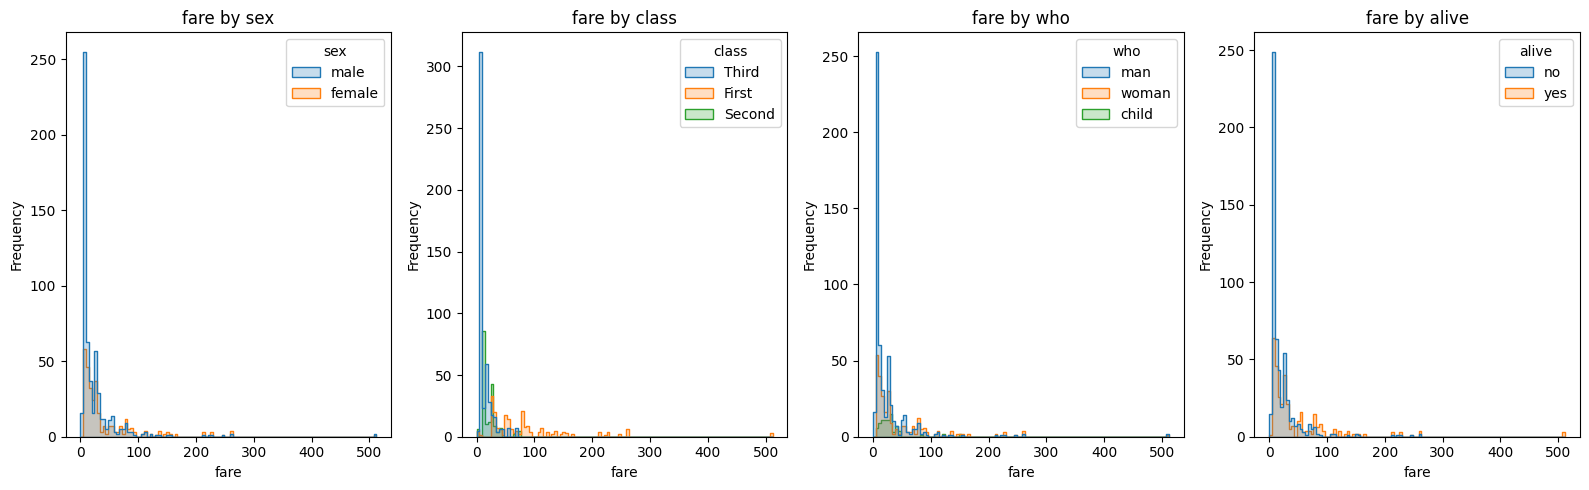

['sex', 'class', 'who', 'alive']

In [20]:
plot_features_cat_regression(titanic_df, 'fare')